# HCP Vector Pipeline

## Importing Native Files

In [1]:
import sys
sys.path.append('../Code Files')
sys.path.append('../Data')

## Import Libraries

In [2]:
import datetime
import dill
import matplotlib.pyplot as plt
import numpy as np
from optimization import SGD, GD
import pandas as pd
import re
import scipy
from sklearn.metrics import r2_score
import torch

## Prepare HCP Data

In [3]:
#Load fMRI Resting State Data
with open("../Data/fmri_rs.npy", "rb") as f:
  fmri_rs = np.load(f)

#Print Shape of Data for Sanity
print(fmri_rs.shape)

#Take the Transpose so that each Sample is a Row
fmri_rs = fmri_rs.T

#Get Split to divide into train + test
mat_file = scipy.io.loadmat("../Data/MMP_HCP_60_splits.mat")
seed_1 = mat_file['folds']['seed_1']
subject_lists = seed_1[0, 0]['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0,0].flatten()]

#Get HCP test subjects
HCP_753_Subjects = []
with open('../Data/MMP_HCP_753_subs.txt', 'r') as file:
    HCP_753_Subjects = [int(re.sub('\n', '', line)) for line in file.readlines()]

#Put the HCP test subjects into a dataframe
df = pd.read_csv("../Data/MMP_HCP_componentscores.csv")
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]

(79800, 753)


In [4]:
#Create Train and Test Arrays corresponding to Training and Test Subjects
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

#Reshape Labels into Column Vectors
X_train, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))

## Preprocessing Step

In [5]:
#Row Wise Normalization of Samples
def normalize_rows(matrix: np.ndarray):
    """
    Normalize each row of the given matrix by the norm of the row.
    
    Parameters:
    matrix (numpy.ndarray): The input matrix to be normalized.
    
    Returns:
    numpy.ndarray: The row-normalized matrix.
    """
    # Calculate the L2 norm for each row. Adding a small epsilon to avoid division by zero.
    row_norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    epsilon = 1e-10  # Small value to prevent division by zero
    row_norms[row_norms == 0] = epsilon
    
    # Normalize each row by its norm
    normalized_matrix = matrix / row_norms
    return normalized_matrix

#Preprocess Data
X_train = normalize_rows(X_train)
X_test = normalize_rows(X_test)

## Global Hyperparameters

In [6]:
use_bias = False
lamb = 0.19

## Closed Form Solver

In [7]:
from sklearn.linear_model import Ridge

#Create Ridge Model with specific alpha value and fit to (X_train, Y_train)
model = Ridge(alpha = lamb, solver = 'svd', fit_intercept = use_bias)
model.fit(X_train, Y_train)

#Get Y_train predicted using model weights
Y_train_pred = model.predict(X_train).reshape((-1, 1))
weights = model.coef_.reshape((-1, 1))
W_true = weights

#Calculate Optimal Value
p_star = (np.linalg.norm(Y_train - Y_train_pred) ** 2) + (lamb * (np.linalg.norm(weights) ** 2))
print(f"Value of p^*: {p_star}")

#Compute Training Error Metrics
train_nmse_loss = np.sum(np.square((Y_train_pred - Y_train))) / np.sum(np.square(Y_train))
train_correlation = np.corrcoef(Y_train_pred.flatten(), Y_train.flatten())[0, 1]
train_R2_score = r2_score(Y_train, Y_train_pred)
error_metrics = [train_nmse_loss, train_correlation, train_R2_score]

print('-----------------------------Training Error Metrics---------------------------------')
print(f"NMSE: {train_nmse_loss}")
print(f"Correlation: {train_correlation}")
print(f"R2_Score: {train_R2_score}")

Y_test_predicted =  model.predict(X_test).reshape((-1, 1))

#Compute Test Error Metrics
test_nmse_loss = np.sum(np.square((Y_test_predicted - Y_test))) / np.sum(np.square(Y_test))
test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]
test_R2_score = r2_score(Y_test, Y_test_predicted)
error_metrics = [test_nmse_loss,test_correlation,test_R2_score]

print('-----------------------------Testing Error Metrics---------------------------------')
print(f"NMSE: {test_nmse_loss}")
print(f"Correlation: {test_correlation}")
print(f"R2_Score: {test_R2_score}")

Value of p^*: 893.8554852163037
-----------------------------Training Error Metrics---------------------------------
NMSE: 0.13485415894185068
Correlation: 0.9409419085028259
R2_Score: 0.8188839647676105
-----------------------------Testing Error Metrics---------------------------------
NMSE: 0.729350721526266
Correlation: 0.5008633955204339
R2_Score: 0.21808866080977785


## Gradient Descent[Exact Line Search] Solver

In [8]:
# max_epochs = 1000
# optimizer_code = 0

# hypers = {'lambda': lamb, 'epochs': max_epochs, 'bias': use_bias}
# W_estimated, b_estimated, losses, gap_to_optimality, nee_values, nmse_values, corr_values, R2_values = GD(X = X_train, Y = Y_train, cost_function_code = 1, hypers = hypers, p_star = p_star, W_true = W_true)

In [9]:
# plt.plot(range(1, len(gap_to_optimality)+1), gap_to_optimality)
# plt.title('Gap to Optimality')
# plt.xlabel('Epoch')
# plt.ylabel('Gap to Optimality')
# plt.grid(True)
# plt.show()

In [10]:
# plt.plot(range(1, len(losses)+1), losses)
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()

## Stochastic Gradient Descent Solver

Learning Rate = 1e-3:
- Noticeable difference between the Stochastic Gradients and Full Gradient

Learning Rate = 1e-4:
- Smaller difference

In [11]:
#Cost Function to Use(0 for Least Squares, 1 for Ridge Regression)
cost_function_code = 1

#Hyperparameters
lr = 1e-3
epochs = 100
batch_size = 128
use_bias = False
optimizer_code = 0
hypers = {'lambda': lamb, 'lr': lr, 'epochs': epochs, 'batch_size': batch_size, 'bias': use_bias, 'optimizer_code': optimizer_code}

#Initial Weights
W_init = None

#Run SGD
W_estimated, b_estimated, losses, gap_to_optimality, fixed_point_stochastic_gradients, fixed_point_stochastic_gradient_norms, fixed_point_full_gradients, fixed_point_full_gradient_norms, iterates, iterate_norms, full_gradients, \
    full_gradient_norms, stochastic_gradients, stochastic_gradient_norms, nee_values, nmse_values, corr_values, R2_values, epochs_ran = SGD(X = X_train, Y = Y_train, cost_function_code = cost_function_code, hypers = hypers, optimizer_code = optimizer_code, p_star = p_star, W_true = W_true, W_init = W_init)

Epoch [1/100], Loss: 2582.4600, Gap to Optimality: 1688.6045, Fixed Point Stochastic Gradient Norm: 73.8669, Fixed Point Full Gradient Norm: 1287.0931, Iterate Norm: 1.0668, Full Gradient Norm: 1287.0931,  Stochastic Gradient Norm: 41.8382, NEE: 0.9966404626257309, NMSE: 0.7669244408607483, Correlation: 0.28759268728468645, R2: -0.030018789442541216
Epoch [2/100], Loss: 2476.1704, Gap to Optimality: 1582.3149, Fixed Point Stochastic Gradient Norm: 29.7173, Fixed Point Full Gradient Norm: 461.8293, Iterate Norm: 1.3568, Full Gradient Norm: 461.8293,  Stochastic Gradient Norm: 18.0690, NEE: 0.9938346000217774, NMSE: 0.7353168725967407, Correlation: 0.3195736170786711, R2: 0.012431893320983045
Epoch [3/100], Loss: 2456.2627, Gap to Optimality: 1562.4072, Fixed Point Stochastic Gradient Norm: 33.1145, Fixed Point Full Gradient Norm: 180.1025, Iterate Norm: 1.4627, Full Gradient Norm: 180.1025,  Stochastic Gradient Norm: 12.5176, NEE: 0.9911286948439008, NMSE: 0.7293874621391296, Correlatio

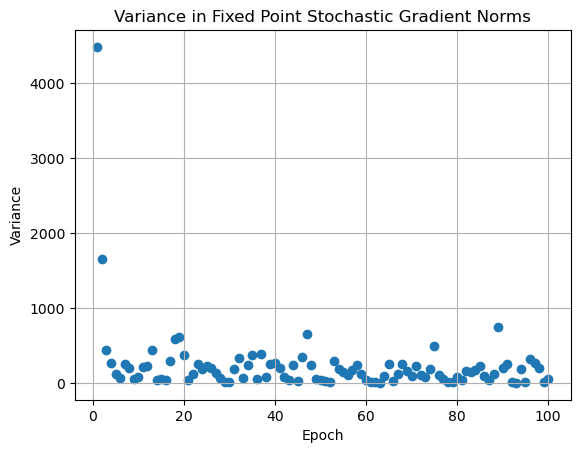

In [12]:
#Fixed Point Stochastic Variance
fixed_point_stochastic_gradient_norms = fixed_point_stochastic_gradient_norms.reshape(epochs_ran, -1)
fixed_point_full_gradient_norms = fixed_point_full_gradient_norms.reshape(epochs_ran, -1)
stochastic_variance_per_epoch = np.var(fixed_point_stochastic_gradient_norms - fixed_point_full_gradient_norms, axis = 1)
plt.scatter(range(1, len(stochastic_variance_per_epoch)+1), stochastic_variance_per_epoch)
plt.title('Variance in Fixed Point Stochastic Gradient Norms')
plt.xlabel('Epoch')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

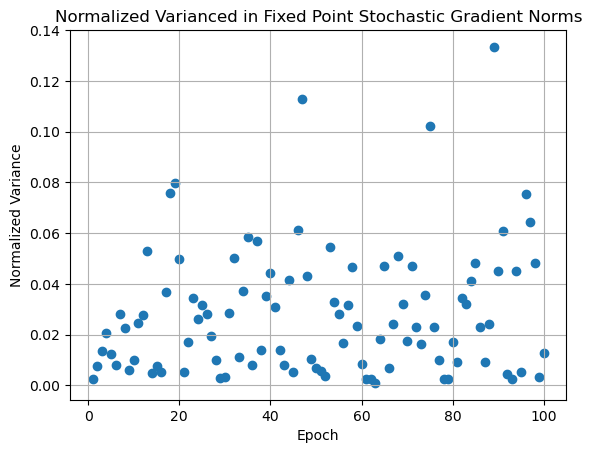

In [13]:
### Normalized Fixed Point Stochastic Variance
normalized_stochastic_variance_per_epoch = np.var((fixed_point_stochastic_gradient_norms - fixed_point_full_gradient_norms) / fixed_point_full_gradient_norms, axis = 1)
plt.scatter(range(1, len(normalized_stochastic_variance_per_epoch)+1), normalized_stochastic_variance_per_epoch)
plt.title('Normalized Varianced in Fixed Point Stochastic Gradient Norms')
plt.xlabel('Epoch')
plt.ylabel('Normalized Variance')
plt.grid(True)
plt.show()

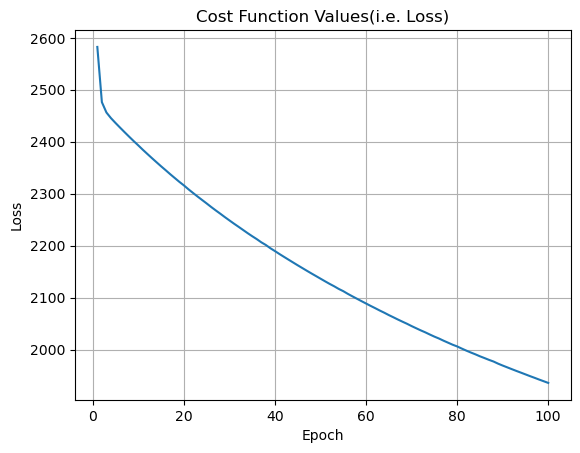

In [14]:
#Cost Function Value
plt.plot(range(1, len(losses)+1), losses)
plt.title('Cost Function Values(i.e. Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

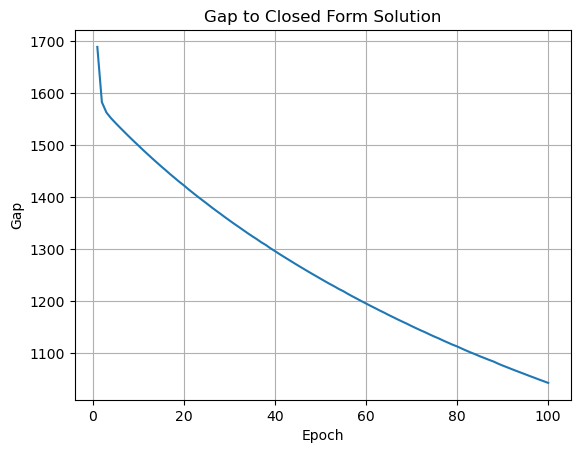

In [15]:
#Gap to Closed Form Solution
plt.plot(range(1, len(gap_to_optimality)+1), gap_to_optimality)
plt.title('Gap to Closed Form Solution')
plt.xlabel('Epoch')
plt.ylabel('Gap')
plt.grid(True)
plt.show()

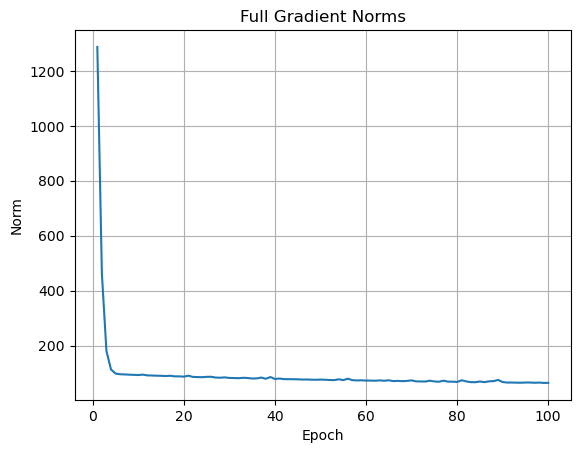

In [16]:
#Plot Full Gradient Norms
plt.plot(range(1, len(full_gradient_norms)+1), full_gradient_norms)
plt.title('Full Gradient Norms')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.grid(True)
plt.show()

### Stochastic Gradient Descent vs Full Gradients

In [17]:
## Least Squares Term: ||XW - Y||_2^2 
## Gradient of Least Squares Term: Summation of Gradients of (<xi, w>  - yi)^2

## L2 Loss Term: ||W||_2^2 
## Gradient of L2 Loss Term: 2w

stochastic_group_size = int(len(stochastic_gradients) / epochs_ran) #number of gradients within a stochastic group

#Store Stuff
A = []
A_norms = []
A_avg = []

#Iterate through Full Gradients
for idx in range(len(full_gradients)):
    full_gradient = full_gradients[idx] #Get Full Gradient
    
    #Get Stochastic Gradients
    start = idx * stochastic_group_size
    end = (idx + 1) * stochastic_group_size
    stochastic_slice = stochastic_gradients[start:end]
    
    #Compute Sum of Stochastic Gradients
    stochastic_sum = 0
    for idx2 in range(len(stochastic_slice)):
        stochastic_sum += stochastic_slice[idx2]
    
    #Compute Normalized Difference
    normalized_diff = (stochastic_sum - full_gradient) / full_gradient
    A.append(normalized_diff)    
    A_norms.append(torch.norm(normalized_diff).item())
    A_avg.append(torch.mean(normalized_diff))

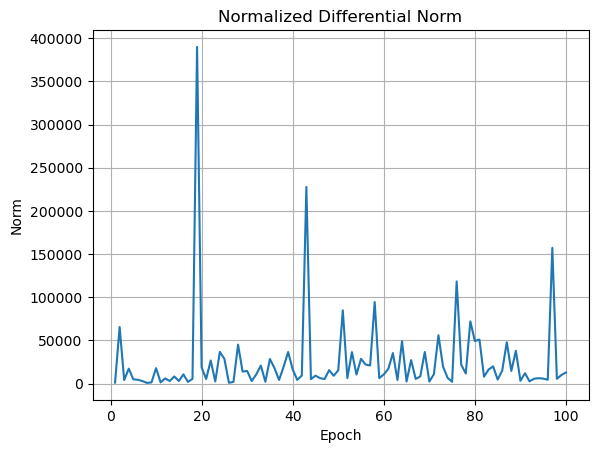

In [18]:
plt.plot(range(1, len(A_norms)+1), A_norms)
plt.title('Normalized Differential Norm')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.grid(True)
plt.show()

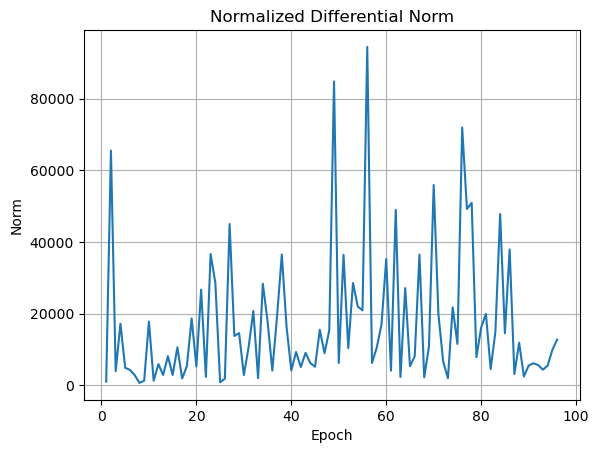

In [19]:
A_norms = np.array(A_norms)
filtered_A_norms = A_norms[A_norms <= 1e5]
plt.plot(range(1, len(filtered_A_norms)+1), filtered_A_norms)
plt.title('Normalized Differential Norm')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.grid(True)
plt.show()

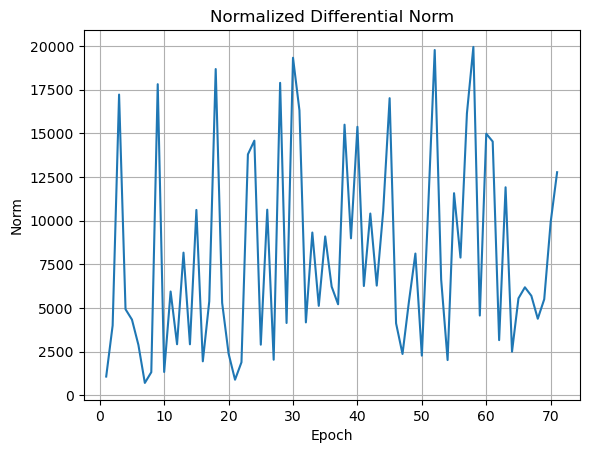

In [20]:
A_norms = np.array(A_norms)
filtered_A_norms = A_norms[A_norms <= 2e4]
plt.plot(range(1, len(filtered_A_norms)+1), filtered_A_norms)
plt.title('Normalized Differential Norm')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.grid(True)
plt.show()

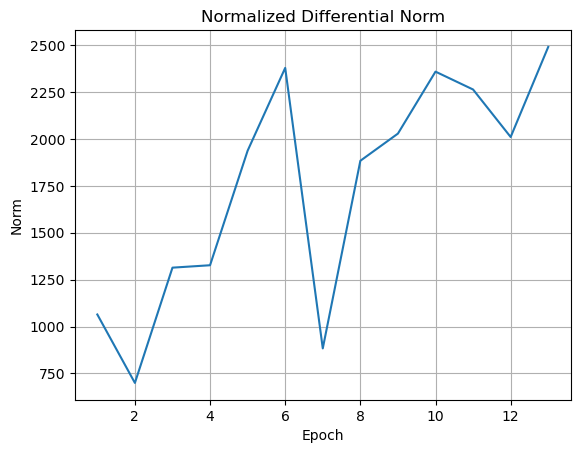

In [21]:
A_norms = np.array(A_norms)
filtered_A_norms = A_norms[A_norms <= 2.5e3]
plt.plot(range(1, len(filtered_A_norms)+1), filtered_A_norms)
plt.title('Normalized Differential Norm')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.grid(True)
plt.show()

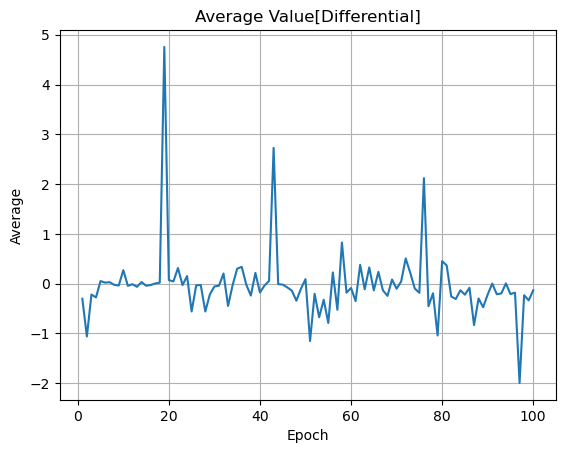

In [22]:
plt.plot(range(1, len(A_avg)+1), A_avg)
plt.title('Average Value[Differential]')
plt.xlabel('Epoch')
plt.ylabel('Average')
plt.grid(True)
plt.show()

In [23]:
## Compute the Sum of the Gradients of the L2 Norms during each epoch(i.e. across all stochastic updates within the epoch)
iterate_norm_tensor_sums = []
for epoch in range(epochs_ran):
    start = epoch * (stochastic_group_size)
    end = (epoch + 1) * (stochastic_group_size)
    iterate_slice = iterates[start: end]
    
    iterate_sum = 0
    
    for idx2 in range(len(iterate_slice)):
        iterate_sum += iterate_slice[idx2]
    
    iterate_norm_tensor_sums.append(torch.norm(iterate_sum))

iterate_norm_tensor_sums

[tensor(5.1073),
 tensor(7.5349),
 tensor(8.6001),
 tensor(8.9765),
 tensor(9.2434),
 tensor(9.4786),
 tensor(9.6948),
 tensor(9.9276),
 tensor(10.2015),
 tensor(10.5235),
 tensor(10.6703),
 tensor(11.0923),
 tensor(11.3467),
 tensor(11.7394),
 tensor(12.0471),
 tensor(12.4431),
 tensor(12.7275),
 tensor(13.1592),
 tensor(13.5021),
 tensor(13.9553),
 tensor(14.1945),
 tensor(14.6552),
 tensor(15.0430),
 tensor(15.4663),
 tensor(15.8345),
 tensor(16.1844),
 tensor(16.6125),
 tensor(16.9726),
 tensor(17.4505),
 tensor(17.8285),
 tensor(18.1972),
 tensor(18.6491),
 tensor(19.0155),
 tensor(19.3834),
 tensor(19.7980),
 tensor(20.1875),
 tensor(20.6591),
 tensor(21.0289),
 tensor(21.3016),
 tensor(21.7403),
 tensor(22.2112),
 tensor(22.5354),
 tensor(22.9681),
 tensor(23.2972),
 tensor(23.7191),
 tensor(24.1094),
 tensor(24.4496),
 tensor(24.8653),
 tensor(25.2400),
 tensor(25.5848),
 tensor(25.9468),
 tensor(26.3529),
 tensor(26.7276),
 tensor(27.0416),
 tensor(27.4282),
 tensor(27.8572),


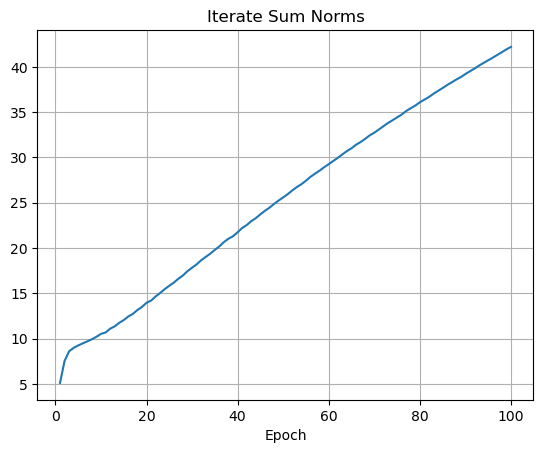

In [24]:
plt.plot(range(1, len(iterate_norm_tensor_sums)+1), iterate_norm_tensor_sums)
plt.title('Iterate Sum Norms')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

-----------------------------Testing Error Metrics---------------------------------
NEE: 0.7997152834049241
NMSE: 0.8874630598759974
Correlation: 0.3608061347586456
R2_Score: 0.048581965919802794
Bias: 0


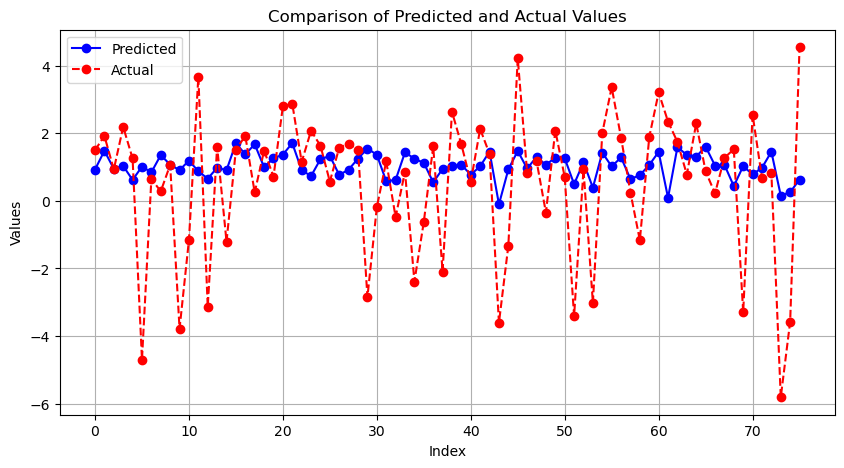

In [25]:
#Testing
weights = W_estimated
use_bias = b_estimated
Y_test_predicted = X_test @ W_estimated + use_bias

#Compute NEE, NMSE, Correlation, and R^2 Score
test_normalized_estimation_error = ((np.linalg.norm(W_estimated - W_true)) ** 2) /  ((np.linalg.norm(W_true)) ** 2)
test_nmse_loss = np.sum(np.square((Y_test_predicted - Y_test))) / np.sum(np.square(Y_test))
test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]
test_R2_score = r2_score(Y_test, Y_test_predicted)

error_metrics = [test_normalized_estimation_error,test_nmse_loss,test_correlation,test_R2_score]

print('-----------------------------Testing Error Metrics---------------------------------')
print(f"NEE: {test_normalized_estimation_error}")
print(f"NMSE: {test_nmse_loss}")
print(f"Correlation: {test_correlation}")
print(f"R2_Score: {test_R2_score}")
print(f"Bias: {use_bias}")

# Plotting both arrays
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(Y_test_predicted, label='Predicted', color='blue', marker='o')  # Plot Y_test_predicted
plt.plot(Y_test, label='Actual', color='red', linestyle='--', marker='o')  # Plot Y_test with dashed line
plt.title(f"Comparison of Predicted and Actual Values")  # Title of the plot
plt.xlabel('Index')  # Label for the x-axis
plt.ylabel('Values')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot